# 3.1 MNIST

In [12]:
import numpy as np

from sklearn.datasets import fetch_openml

import matplotlib as mpl

import matplotlib.pyplot as plt

from sklearn.linear_model import SGDClassifier #사이킷런의 확률적 경사 하강법 분류기.(선형분류) 한번에 하나씩 훈련 샘플을 독립적으로 처리.

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 불러들인 데이터셋은 일반적으로 비슷한 딕셔너리 구조를 가짐. 아래의 3가지 key는 보통 포함함.<br>
DESCR key: 데이터 셋을 설명<br>
data key: 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가짐<br>
target key: 레이블 배열을 담음.


In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
#이미지가 70000개 있고 각 이미지별로 784개의 특성(28x28픽셀)이 있음.

(70000, 784)

In [4]:
y.shape #70000개의 이미지에 해당하는 레이블이 각각 한개, 총 70000여개 있음. (아마 0~9로 이뤄짐)

(70000,)

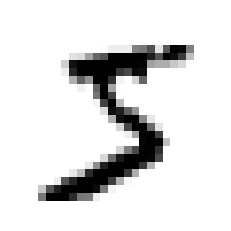

In [5]:
some_digit = X.values[0] #데이터셋 중 하나의 샘플을 확인해보기 위해서 지정
                         #X[0]에서 오류가 발생하는 이유는 scikitlearn의 버전에 따라 fetch_openml의 as_frame 인자의 default값이 다르기 때문.
                            #참고: https://github.com/ageron/handson-ml2/issues/352
some_digit_image = some_digit.reshape(28, 28) #reshape는 배열의 차원을 변경할때 사용함

plt.imshow(some_digit_image, cmap='binary') #imshow는 python에서 matplotlib을 활용해 이미지를 표시할 때 사용함. 
                                            #배열을 준 후 컬러맵으로 binary 옵션을 지정한 것.
                                            #출처: https://pyvisuall.tistory.com/78
plt.axis("off") #축은 표시 안함.
plt.show()

In [6]:
y[0] #y.values[0]을 사용해도 됨.

'5'

In [8]:
y = y.astype(np.uint8) #레이블 값이 문자열인데 머신러닝 알고리즘에서는 주로 정수형을 기대하므로 y의 값들을 모두 정수형으로 변환함.
                       #numpy의 데이터타입은 https://kongdols-room.tistory.com/53 참고

MNIST 데이터셋은 이미 training set와 test set을 60000, 10000으로 나눠놨음. 또한 훈련세트는 이미 잘 섞여 있음.(데이터 셋이 잘 섞여 있다.)<br>

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# 3.2 이진 분류기 훈련

데이터를 2가지 경우의 클래스로 분류하는 것을 이진 분류(binary classification)이라고 함.

In [10]:
y_train_5 = (y_train == 5) #이 경우에 5는 True, 나머지 숫자는 모두 False가 됨.
y_test_5 = (y_test == 5)

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

확률적 경사하강법 참고: https://gooopy.tistory.com/69

In [14]:
sgd_clf.predict([some_digit]) #맨 처음 지정한 이미지를 5라고 판단함. 하지만 이 한번의 경우로 모델의 성능을 평가할 수 없음.

array([ True])

# 3.3 성능 측정

classifier 평가는 회귀 모델 평가보다 어려움.<br>
또한 모델 평가에 사용할 수 있는 성능 지표로 여러개가 존재함.<br>
1. 교차 검증을 활용한 정확도 측정
2. 오차 행렬을 활용한 정확도 측정
3. 정밀도와 재현율 활용
4. ROC 곡선(수신기 조작 특성 곡선) 활용